In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [8]:
with open('full_us.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

stations_df = pd.DataFrame(data)

In [18]:
print("=" * 80)
print("BASIC STATISTICS")
print("=" * 80)
print(f"Total number of stations: {len(stations_df)}")
print(f"\nColumns: {list(stations_df.columns)}")

# Extract nested data
stations_df['elevation'] = stations_df['location'].apply(lambda x: x.get('elevation') if isinstance(x, dict) else None)
stations_df['station_name'] = stations_df['name'].apply(lambda x: x.get('en') if isinstance(x, dict) else None)
stations_df['icao'] = stations_df['identifiers'].apply(lambda x: x.get('icao') if isinstance(x, dict) else None)

print("\n" + "=" * 80)
print("GEOGRAPHICAL DISTRIBUTION")
print("=" * 80)

# Stations by region/state
region_counts = stations_df['region'].value_counts()
number_of_regions = len(region_counts)
print(f"\nNumber of unique states/regions: {number_of_regions}")
print(f"\nStates/regions by number of stations:")
print(region_counts)

print("\n" + "=" * 80)
print("ELEVATION ANALYSIS")
print("=" * 80)

# Elevation statistics
elevation_stats = stations_df['elevation'].describe()
print(f"\nElevation statistics (meters):")
print(elevation_stats)

# Find extreme elevations
print(f"\nHighest elevation stations:")
print(stations_df.nlargest(10, 'elevation')[['station_name', 'region', 'elevation']])

print(f"\nLowest elevation stations:")
print(stations_df.nsmallest(10, 'elevation')[['station_name', 'region', 'elevation']])

print("\n" + "=" * 80)
print("TIMEZONE ANALYSIS")
print("=" * 80)

timezone_counts = stations_df['timezone'].value_counts()
print(f"\nStations by timezone:")
print(timezone_counts)

BASIC STATISTICS
Total number of stations: 2935

Columns: ['id', 'name', 'country', 'region', 'identifiers', 'location', 'timezone', 'inventory', 'elevation', 'station_name', 'icao']

GEOGRAPHICAL DISTRIBUTION

Number of unique states/regions: 55

States/regions by number of stations:
region
TX    215
AK    200
CA    173
FL    118
MN    107
GA     88
MI     87
NC     85
WI     80
VA     73
CO     73
IL     68
OK     65
IA     63
WA     62
NY     62
KS     61
LA     59
OH     59
NE     55
TN     54
AZ     51
PA     50
OR     50
SC     50
HI     49
MO     49
MT     49
IN     49
NM     48
AL     48
WY     43
KY     41
MS     40
ND     40
AR     39
UT     31
NV     31
MA     30
ID     29
ME     27
SD     27
MD     27
NJ     19
NH     17
WV     17
VT     14
CT     11
RI      6
DE      4
DC      1
RO      1
SA      1
TI      1
WQ      1
Name: count, dtype: int64

ELEVATION ANALYSIS

Elevation statistics (meters):
count    2935.000000
mean      388.147189
std       592.639875
min     -9999.00

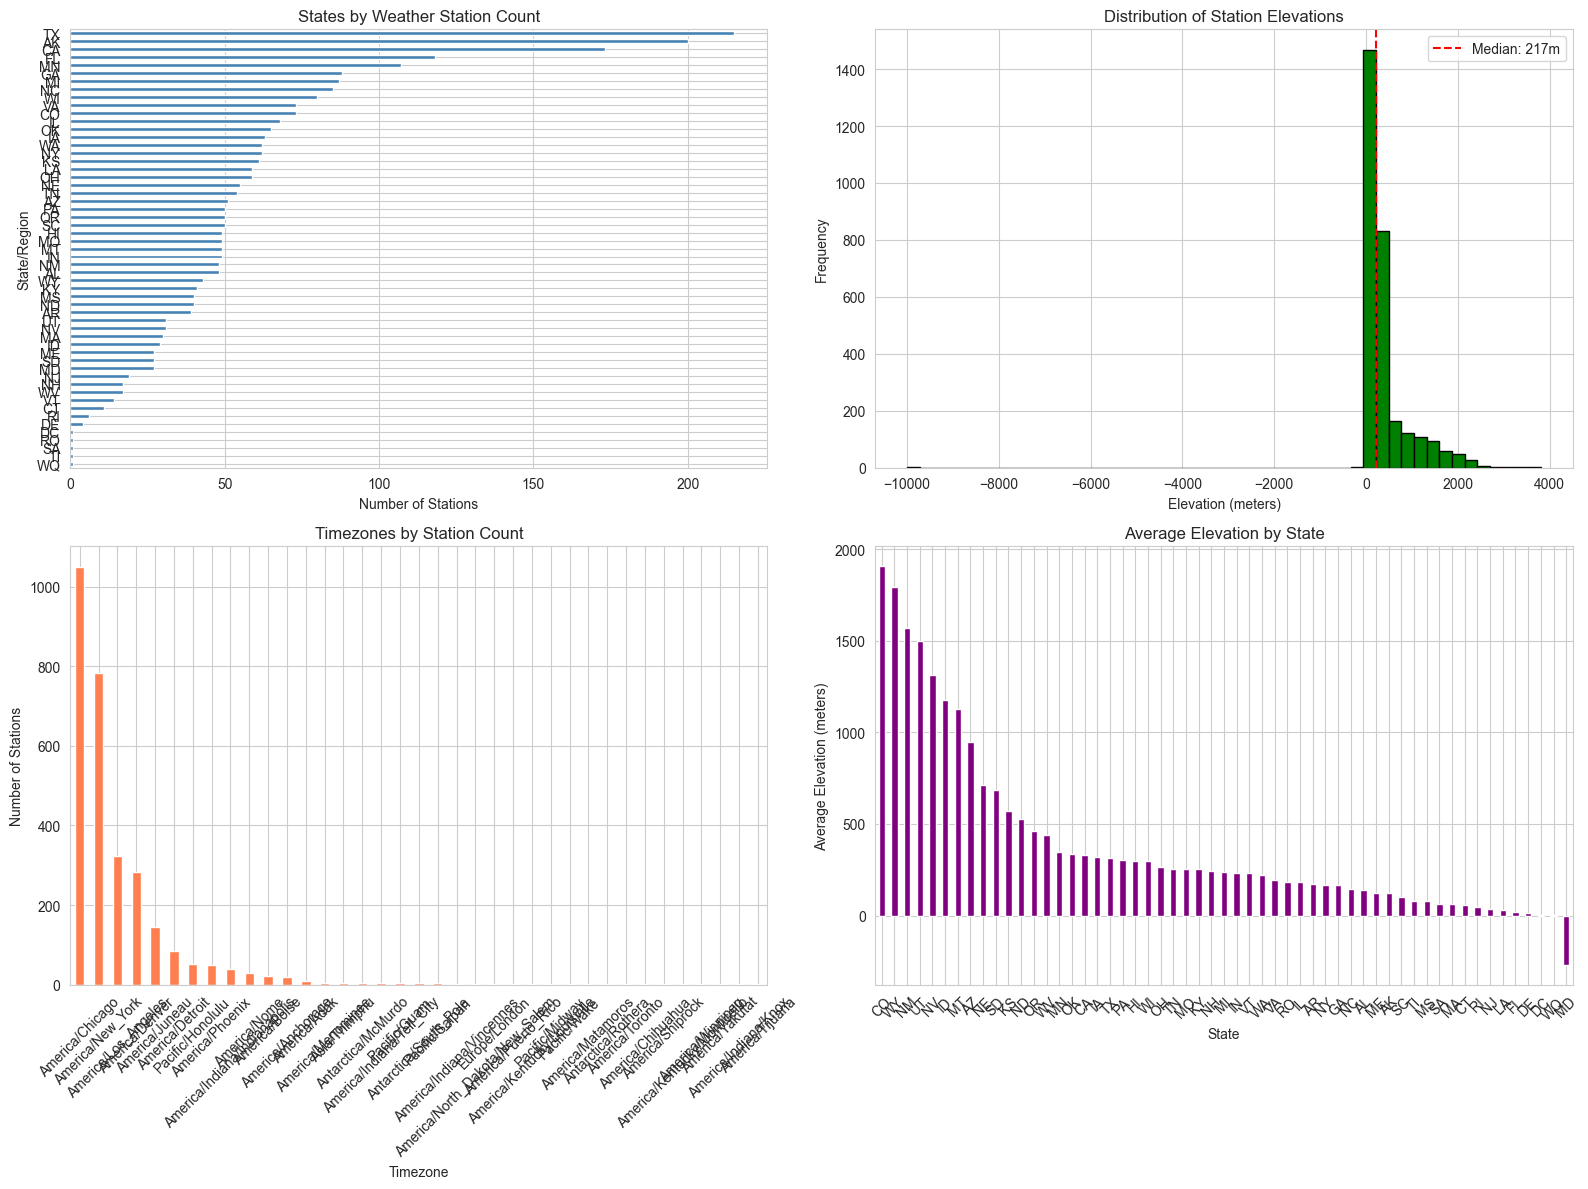

In [20]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. States by Station Count
ax1 = axes[0, 0]
states = region_counts
states.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Number of Stations')
ax1.set_ylabel('State/Region')
ax1.set_title('States by Weather Station Count')
ax1.invert_yaxis()

# 2. Elevation Distribution
ax2 = axes[0, 1]
stations_df['elevation'].hist(bins=50, ax=ax2, color='green', edgecolor='black')
ax2.set_xlabel('Elevation (meters)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Station Elevations')
ax2.axvline(stations_df['elevation'].median(), color='red', linestyle='--', label=f"Median: {stations_df['elevation'].median():.0f}m")
ax2.legend()

# 3. Timezone Distribution
ax3 = axes[1, 0]
timezone_top = timezone_counts
timezone_top.plot(kind='bar', ax=ax3, color='coral')
ax3.set_xlabel('Timezone')
ax3.set_ylabel('Number of Stations')
ax3.set_title('Timezones by Station Count')
ax3.tick_params(axis='x', rotation=45)

# 4. Elevation by State
ax4 = axes[1, 1]
states = region_counts.index
elevation_by_state = stations_df[stations_df['region'].isin(states)].groupby('region')['elevation'].mean().sort_values(ascending=False)
elevation_by_state.plot(kind='bar', ax=ax4, color='purple')
ax4.set_xlabel('State')
ax4.set_ylabel('Average Elevation (meters)')
ax4.set_title('Average Elevation by State')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "=" * 80)
print("INTERESTING PATTERNS")
print("=" * 80)

# Alaska stations
alaska_count = len(stations_df[stations_df['region'] == 'AK'])
print(f"\nAlaska has {alaska_count} stations ({alaska_count/len(stations_df)*100:.1f}% of all stations)")

# Coastal stations (elevation < 50m)
coastal = len(stations_df[stations_df['elevation'] < 50])
print(f"\nCoastal stations (< 50m elevation): {coastal} ({coastal/len(stations_df)*100:.1f}%)")

# Mountain stations (elevation > 1500m)
mountain = len(stations_df[stations_df['elevation'] > 1500])
print(f"Mountain stations (> 1500m elevation): {mountain} ({mountain/len(stations_df)*100:.1f}%)")

# Airport stations (contains 'Airport' or 'Air Force Base' in name)
airport_keywords = ['Airport', 'Air Force Base', 'AFB', 'Airfield', 'Airpark']
airport_stations = stations_df[stations_df['station_name'].str.contains('|'.join(airport_keywords), case=False, na=False)]
print(f"\nAirport/Military stations: {len(airport_stations)} ({len(airport_stations)/len(stations_df)*100:.1f}%)")

# Create a regional summary
regional_summary = stations_df.groupby('region').agg({
    'id': 'count',
    'elevation': ['mean', 'min', 'max'],
    'icao': lambda x: x.notna().sum()
}).round(2)

regional_summary.columns = ['Station_Count', 'Avg_Elevation', 'Min_Elevation', 'Max_Elevation', 'ICAO_Count']
regional_summary = regional_summary.sort_values('Station_Count', ascending=False)

print("\n" + "=" * 80)
print("REGIONAL SUMMARY (Top 20)")
print("=" * 80)
print(regional_summary.head(20))


INTERESTING PATTERNS

Alaska has 200 stations (6.8% of all stations)

Coastal stations (< 50m elevation): 717 (24.4%)
Mountain stations (> 1500m elevation): 175 (6.0%)

Airport/Military stations: 503 (17.1%)

REGIONAL SUMMARY (Top 20)
        Station_Count  Avg_Elevation  Min_Elevation  Max_Elevation  ICAO_Count
region                                                                        
TX                215         314.35              2           1663         213
AK                200         120.82              0           1002         193
CA                173         329.62            -69           2175         164
FL                118          17.55              0             88         104
MN                107         345.50              3            548         104
GA                 88         169.36              0            582          86
MI                 87         236.70              3            446          80
NC                 85         144.87              0  